In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# HW2

#### **Задание**: Реализовать взвешенное голосование между градиентным бустингом с логистической функцией потерь, AdaBoost и SVM. Реализацию SVM и AdaBoost взять из sklearn.

In [2]:
import pandas as pd
import numpy as np
from sklearn import cross_validation as cv
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv("./spam.train.txt", delim_whitespace=True, header=None)
x_data = df.ix[:, 1:].as_matrix(); y_data = df.ix[:, 0].as_matrix()
y_data[y_data == 0] = -1
x_train, x_test, y_train, y_test = cv.train_test_split(x_data, y_data,
                                                       test_size=0.25, random_state=288)


# CART Implementation 

In [4]:
from src.CART import CART, best_split_mse
from src.model_tree import best_split_mse_brute_force

In [ ]:
%timeit CART().fit(x_train, y_train)

In [ ]:
def run_cv(X, y):
    kf = KFold(len(y), n_folds=3)

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cart = CART()
        cart.fit(X_train, y_train)
        y_pred = cart.predict(X_test)
        print "Cart :", mean_squared_error(y_test, y_pred)
        
        dtr = DecisionTreeRegressor(max_depth=4)
        dtr.fit(X_train, y_train)
        y_pred = dtr.predict(X_test)
        print "SKlearn:", mean_squared_error(y_test, y_pred)
        
run_cv(x_train, y_train)

# GBoost Implementation

In [5]:
from src.GBoost import GBoost

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gboost = GBoost(10)
gboost.fit(x_train, y_train)

In [ ]:
pred = gboost.predict(x_test)
f1_score(y_test, pred)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=4)
gbc.fit(x_train, y_train)
pred = gbc.predict(x_test)
f1_score(y_test, pred)

# Performance Graph

In [ ]:
from src.benchmark import draw_graph_hw1

In [ ]:
# Tooo long
gboost_scores, sklearn_scores = draw_graph_hw1(x_train, x_test, y_train, y_test, 100)


In [ ]:
np.savez("scores100_f1.dat", gboost_scores=gboost_scores, sklearn_scores=sklearn_scores)

In [37]:
scores = np.load('./scores100_f1.dat.npz')

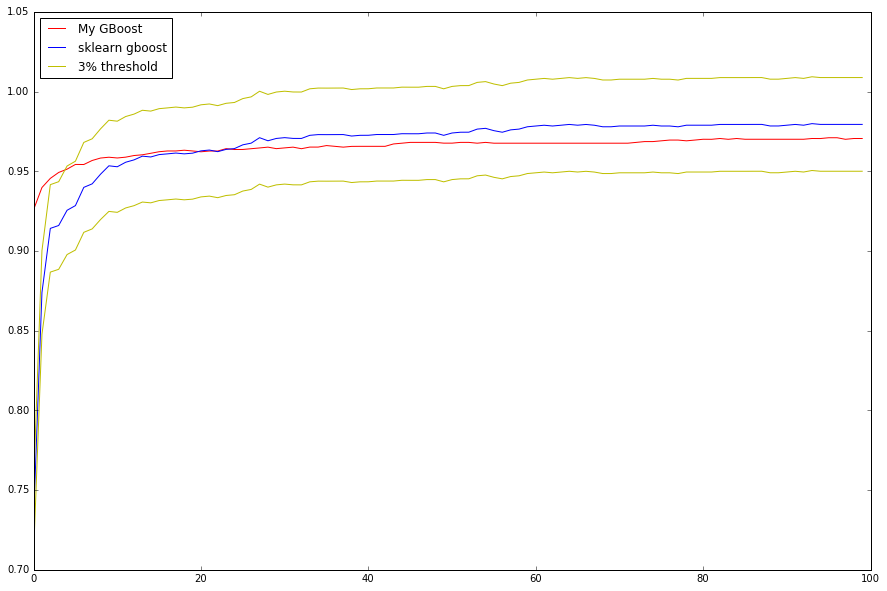

In [39]:
gboost_fig = plt.figure(figsize=(15, 10))

plt.plot(range(len(scores["gboost_scores"])), (scores["gboost_scores"]), c="r", label='My GBoost')
plt.plot(range(len(scores["sklearn_scores"])), (scores["sklearn_scores"]), c="b", label='sklearn gboost')
plt.plot(range(len(scores["sklearn_scores"])), (scores["sklearn_scores"])*1.03, c="y", label='3% threshold')
plt.plot(range(len(scores["sklearn_scores"])), (scores["sklearn_scores"])*0.97, c="y")

plt.legend(loc='upper left')

In [40]:
gboost_fig.savefig("gboost_score.png")

# Weighted Majority

![http://www.kddresearch.org/Courses/Fall-2003/CIS732/Lectures/Lecture-20-20021107.pdf](http://take.ms/HrNMf)

### GBoost

In [14]:
gboost = GBoost(100)
gboost.fit(x_train, y_train)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [15]:
y_pred = gboost.predict(x_test)
f1_score(y_test, y_pred)

0.97053045186640463

### AdaBoost

In [4]:
from sklearn.grid_search import GridSearchCV

In [5]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
tuned_parameters = [{
    'algorithm': ['SAMME', 'SAMME.R'],
    'learning_rate': [0.2, 0.4, 0.7, 1.0],
     'n_estimators': [50, 150, 250]
}]

scores = ['f1']

for score in scores:
    clf = GridSearchCV(AdaBoostClassifier(), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

In [6]:
from sklearn.ensemble import AdaBoostClassifier

ada_best_params = {'n_estimators': 250, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}

ada_Boost_clf = AdaBoostClassifier(**ada_best_params)
ada_Boost_clf.fit(x_train, y_train)
y_pred = ada_Boost_clf.predict(x_test)
f1_score(y_test, y_pred)

0.97220867869332028

### SVM

In [7]:
from sklearn.svm import SVC

In [ ]:
tuned_parameters = [{
    'kernel': ['rbf'],
    'gamma': [1e-3, 1e-4],
     'C': [1, 10, 100, 1000]
}, {
    'kernel': ['linear'],
    'C': [1, 10, 100, 1000]
}]

scores = ['f1']

for score in scores:
   
    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

In [8]:
from sklearn.svm import SVC

svc_best_params = {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

svc = SVC(**svc_best_params)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
f1_score(y_test, y_pred)

0.9658203125

In [17]:
predictors = [gboost, ada_Boost_clf, svc]

In [12]:
def weighted_majority(predictors, x_train, y_train, betta = 0.65):
    n_samples = x_train.shape[0]
    m_predictors = len(predictors)
    w = np.ones(m_predictors)
    
    prediction = np.zeros((n_samples, m_predictors))
    
    for n in range(n_samples):
        qneg = 0; qpos = 0
        
        for m in range(m_predictors):
            pred = predictors[m].predict([x_train[n,:]])[0]

            qneg += w[m] if pred == -1 else 0
            qpos += w[m] if pred == 1 else 0
            
            if qneg > qpos:
                prediction[n, m] = -1
            elif qneg == qpos:
                prediction[n, m] = 1 if np.random.randint(0,2) else -1
            else:
                prediction[n, m] = 1

            if prediction[n, m] != y_train[n]:
                w[m] *= betta
    return np.array(w)

In [13]:
def weighted_predictor(x, predictors, weights):
    pred = np.array([p.predict(x) for p in predictors])
    pos = np.sum(np.multiply(pred == 1, weights[:, np.newaxis]), axis=0)
    neg = np.sum(np.multiply(pred == -1, weights[:, np.newaxis]), axis=0)
    y_pred = np.argmax(np.vstack((neg, pos)), axis=0)
    y_pred[y_pred == 0] = -1
    return y_pred

In [18]:
weights = weighted_majority(predictors, x_train, y_train)

In [19]:
weights

array([ 1.        ,  0.65      ,  0.04902228])

In [20]:
y_pred = weighted_predictor(x_test, predictors, weights)
f1_score(y_test, y_pred)

0.97053045186640463

In [31]:
f_w = np.zeros(x_train.shape[1])

def wide_walk(tree, feature_weigths):
    if tree.split_feature is None:
        return feature_weigths
    
    feature_weigths[tree.split_feature] += tree.score
    
    feature_weigths = wide_walk(tree.fb, feature_weigths)
    feature_weigths = wide_walk(tree.tb, feature_weigths)
    
    return feature_weigths
# wide_walk(gboost.ensembles[3].tree, f_w)
embedded_features = np.argsort(np.sum(
    np.array([wide_walk(p.tree, np.zeros(x_train.shape[1])) for p in predictors[0].ensembles]),
    axis=0))[::-1]

In [20]:
#np.savez("embedded_features.dat", embedded_features)
embedded_features = np.load('./embedded_features.dat.npz')["arr_0"]

In [21]:
from src.benchmark import predict_on_fsubset, fset2scores

In [22]:
embedded_clfs, embedded_scores, embedded_times = fset2scores(embedded_features, x_train, x_test, y_train, y_test)

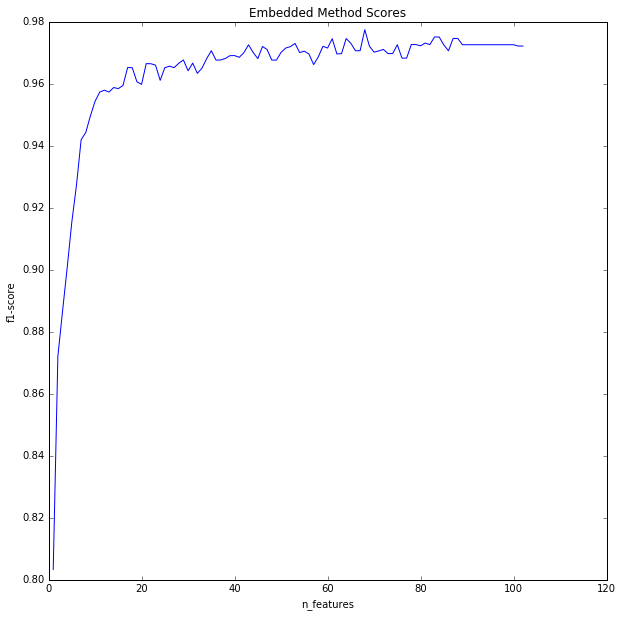

In [24]:
embedded_fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, len(embedded_features)+1), embedded_scores)
plt.title('Embedded Method Scores')

plt.xlabel('n_features')
plt.ylabel('f1-score')
embedded_fig.savefig('embedded_method_score.png')

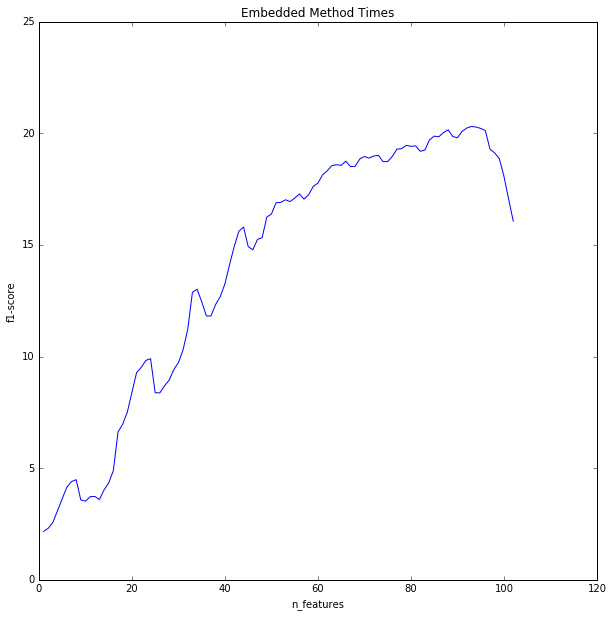

In [23]:
embedded_fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, len(embedded_features)+1), embedded_times)
plt.title('Embedded Method Times')

plt.xlabel('n_features')
plt.ylabel('f1-score')
embedded_fig.savefig('embedded_method_times.png')